### Імпортування бібліотек

In [3]:
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, learning_curve
import torch
import torch.nn.functional as F
from sklearn.metrics import make_scorer, precision_score, classification_report
from sklearn.neural_network import MLPClassifier

import numpy as np
import matplotlib.pyplot as plt

In [20]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Зчитування даних з обробленого датасету

In [5]:
ds = pd.read_csv('../data/variant_1_modified.csv')
print(ds['Status'])
ds = ds.drop(["ID", "year", "Upfront_charges"], axis="columns")

0         1
1         1
2         0
3         0
4         0
         ..
148665    0
148666    0
148667    0
148668    0
148669    0
Name: Status, Length: 148670, dtype: int64


In [6]:
X = ds.drop(['Status'], axis=1)
Y = ds['Status']

### Розподіл даних

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)

### Перетворення даних на тензори для обробки нейронною мережею

In [8]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create PyTorch data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

### Оголошення нейронної мережі на основі MLP 

In [9]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        
        # Define the input layer
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        
        # Define the hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        
        # Define the output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x

### Запис критеріону та оптимізатора

In [10]:
input_size = X.shape[1]  # Number of features
hidden_size = [64]  # Specify hidden_size as a list with a single element
num_classes = 2  # Replace 2 with the number of classes in your dataset
model = MLP(input_size, hidden_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Тренування моделі

In [11]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/20], Loss: 381.9311
Epoch [2/20], Loss: 73.8712
Epoch [3/20], Loss: 57.3901
Epoch [4/20], Loss: 49.8146
Epoch [5/20], Loss: 36.6759
Epoch [6/20], Loss: 34.7022
Epoch [7/20], Loss: 29.3975
Epoch [8/20], Loss: 24.5053
Epoch [9/20], Loss: 20.9707
Epoch [10/20], Loss: 19.5528
Epoch [11/20], Loss: 18.7855
Epoch [12/20], Loss: 15.1863
Epoch [13/20], Loss: 14.6101
Epoch [14/20], Loss: 11.9910
Epoch [15/20], Loss: 9.9330
Epoch [16/20], Loss: 9.0255
Epoch [17/20], Loss: 5.4801
Epoch [18/20], Loss: 2.9133
Epoch [19/20], Loss: 1.0500
Epoch [20/20], Loss: 0.6941


In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f'Accuracy on test set: {accuracy:.2%}')

Accuracy on test set: 77.55%


### Оголошення гіперпараметрів для тьюнінгу моделі

In [13]:
param_grid = {
    'hidden_layer_sizes': [(64,), (128,)],  # Define different hidden layer sizes
    'activation': ['relu', 'tanh'],  # Activation function options
    'solver': ['adam'],  # Optimization algorithm
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'learning_rate_init': [0.001, 0.01],  # Initial learning rate
}

# Define precision scorer
precision_scorer = make_scorer(precision_score, average='weighted')

# Instantiate MLP classifier
mlp = MLPClassifier()

# Create GridSearchCV object
grid = GridSearchCV(estimator=mlp,
                    param_grid=param_grid,
                    scoring=precision_scorer,  # Use custom precision scorer
                    cv=5,  # Number of cross-validation folds
                    verbose=3,  # Verbosity level
                    return_train_score=True)

# Fit the grid search to the training data
grid.fit(X_train, y_train)

# Print the best parameters and best score
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.747, test=0.753) total time=  58.3s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.819, test=0.816) total time=  30.6s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.681, test=0.675) total time=  35.2s
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.825, test=0.824) total time=  57.6s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.827, test=0.826) total time= 1.1min
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.814, test

c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.814, test=0.567) total time=  21.0s
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.814, test=0.567) total time=  23.7s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.814, test=0.567) total time=  22.3s
[CV 5/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.814, test=0.814) total time=  20.2s
[CV 1/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.814, test=0.813) total time=  54.0s
[CV 2/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.827, test=0.829) total time= 1.7min
[CV 3/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.805, test=0.805) total time= 1.0min
[CV 4/5] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.828, test=0.827) total time= 1.2min
[CV 5/5] END activation=relu, al

c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  16.6s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  21.5s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.806, test=0.815) total time=  17.3s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.776, test=0.814) total time=   9.9s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  12.1s
[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.809, test=0.804) total time=  27.3s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.763, test=0.763) total time=  13.4s
[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.818, test=0.818) total time=  15.8s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.813, test=0.813) total time=  16.3s
[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.807, test=0.807) total time=  24.8s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.814) total time=  20.1s
[CV 2/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.802, test=0.814) total time=  21.7s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  33.7s
[CV 4/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.815, test=0.815) total time=  18.8s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  11.8s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.808, test=0.802) total time=  17.9s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.826, test=0.823) total time=  22.5s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.786, test=0.782) total time=  11.7s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.817, test=0.815) total time=   8.9s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.823, test=0.822) total time=  16.6s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  15.1s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  10.3s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  10.4s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.802, test=0.815) total time=  11.0s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  15.8s
[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.821, test=0.819) total time=  18.0s
[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.826, test=0.824) total time=  17.3s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.820, test=0.821) total time=  14.8s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.811, test=0.811) total time=  18.2s
[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.819, test=0.817) total time=  31.0s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  13.5s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  12.1s
[CV 3/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.804, test=0.815) total time=  18.6s
[CV 4/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.800, test=0.814) total time=  11.5s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  22.3s
[CV 1/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.824, test=0.824) total time=   9.6s
[CV 2/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.818, test=0.818) total time=  13.4s
[CV 3/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.804, test=0.806) total time=  13.7s
[CV 4/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.746, test=0.748) total time=  15.0s
[CV 5/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate_init=0.001, solver=adam;, score=(train=0.826, test=0.826) total time=  22.1s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=   9.3s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=   9.4s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  16.2s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  11.1s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  15.7s
[CV 1/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.816, test=0.815) total time=  12.1s
[CV 2/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.822, test=0.821) total time=  25.5s
[CV 3/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.825, test=0.825) total time=  15.6s
[CV 4/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.814, test=0.816) total time=  13.1s
[CV 5/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate_init=0.001, solver=adam;, score=(train=0.817, test=0.815) total time=  23.1s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  17.7s
[CV 2/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.796, test=0.814) total time=  19.8s
[CV 3/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.807, test=0.815) total time=  16.9s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 4/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  22.4s


c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 5/5] END activation=tanh, alpha=0.01, hidden_layer_sizes=(128,), learning_rate_init=0.01, solver=adam;, score=(train=0.567, test=0.567) total time=  26.6s
The best parameters are {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.001, 'solver': 'adam'} with a score of 0.82


In [14]:
grid_results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                          pd.DataFrame(grid.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)

grid_results

,activation,alpha,hidden_layer_sizes,learning_rate_init,solver,precision
0,relu,0.0001,"(64,)",0.001,adam,0.778664
1,relu,0.0001,"(64,)",0.010,adam,0.666162
2,relu,0.0001,"(128,)",0.001,adam,0.820719
3,relu,0.0001,"(128,)",0.010,adam,0.752418
4,relu,0.0010,"(64,)",0.001,adam,0.779765
5,relu,0.0010,"(64,)",0.010,adam,0.736841
6,relu,0.0010,"(128,)",0.001,adam,0.771991
7,relu,0.0010,"(128,)",0.010,adam,0.747083
8,relu,0.0100,"(64,)",0.001,adam,0.799053
9,relu,0.0100,"(64,)",0.010,adam,0.779412


In [15]:
grid_results.columns

Index(['activation', 'alpha', 'hidden_layer_sizes', 'learning_rate_init',
       'solver', 'precision'],
      dtype='object')

### Запуск моделі на основі сформованих гіперпараметрів

In [18]:
mlp = MLPClassifier(alpha=0.0001, hidden_layer_sizes=64, learning_rate_init=0.001, solver='adam', activation='tanh', max_iter=100)

mlp.fit(X_train, y_train)

# Evaluate the model
y_pred = mlp.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      1.00      0.87     22439
           1       0.99      0.07      0.13      7295

    accuracy                           0.77     29734
   macro avg       0.88      0.54      0.50     29734
weighted avg       0.82      0.77      0.69     29734



Можемо зробити висновок, що після тьюнінгу моделі ми змогли досягти значно вищої точності

c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\dpopr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


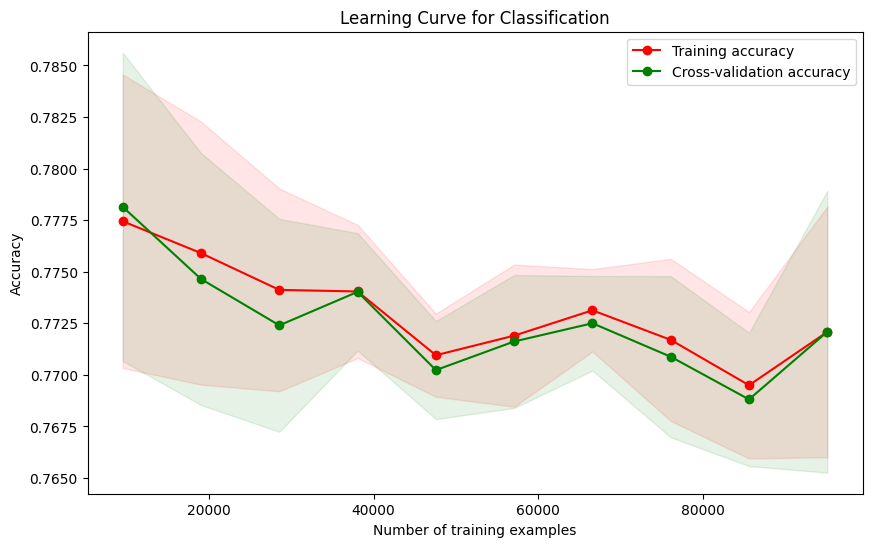

In [19]:
train_sizes, train_scores, test_scores = learning_curve(mlp, X_train_tensor, y_train_tensor, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation accuracy")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Classification")
plt.legend(loc="best")
plt.show()

In [22]:
ds = pd.read_csv('../data/variant_1.csv')

train, new_input = train_test_split(ds, test_size=0.1, random_state=50)

train.to_csv('../data/train.csv', index=False)
new_input.to_csv('../data/new_input.csv', index=False)